In [1]:
import geopandas as gpd
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier


from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, RocCurveDisplay, roc_curve, auc, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, StratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sns

import shap 
import warnings
%matplotlib inline

/opt/anaconda3/envs/scriptsMestrado/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
RANDOM_STATE = 42

In [3]:
dados = gpd.read_file('data/generated/WGS84_hex_agg_sp_filtred.gpkg')

In [4]:
variables = [
    'Households connected to water supply network (%)',
    'Households connected to sewerage system (%)',
    'Households solid waste collection (%)',
    'Number of private residences',
    'Number of buildings areas',
    "Average building area",
    "Average slope"]

categorical_variables = [
    'railway_intersection',
    'highway_intersection',
    'power_intersection',
    'aeroway_intersection',
    'natural_intersection',
    'waterway_intersection'	]


In [5]:
X = dados.copy()[variables + categorical_variables]


# Convert specified columns to integer type using .loc
X.loc[:, categorical_variables] = \
    X.loc[:, categorical_variables].astype(int)
y = dados['is_fcu'].astype(int)

In [6]:
X.head()

,Households connected to water supply network (%),Households connected to sewerage system (%),Households solid waste collection (%),Number of private residences,Number of buildings areas,Average building area,Average slope,railway_intersection,highway_intersection,power_intersection,aeroway_intersection,natural_intersection,waterway_intersection
0,1.000000,1.000000,1.000000,114.0,63.0,147.878013,6.750791,0,0,0,0,0,0
1,1.000000,1.000000,0.991071,157.0,103.0,80.865535,10.788276,0,0,0,0,0,0
2,1.000000,0.976744,0.976744,70.0,26.0,90.313326,7.683747,0,0,0,0,0,0
3,0.997512,0.957711,1.000000,471.0,174.0,60.442236,6.340379,0,0,0,0,0,0
4,1.000000,0.896552,1.000000,20.0,47.0,180.344743,4.947622,0,0,0,0,1,0


In [7]:
# #train test split
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)


In [8]:
def apply_standard_scaler(scaler, df, columns_to_scale):
    # Copy the dataframe to avoid modifying the original
    df_scaled = df.copy()
    
    # Apply StandardScaler only to the specified columns
    df_scaled[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
    
    return df_scaled


In [9]:
#standScaler = StandardScaler()


#X_train_standScaler = apply_standard_scaler(standScaler, X_train, variables)
#X_test_standScaler = apply_standard_scaler(standScaler, X_test, variables)


X_train_standScaler = X_train

X_test_standScaler = X_test


#X_train_standScaler = pd.DataFrame(standScaler.fit_transform(X_train), columns=X.columns)

#X_test_standScaler = pd.DataFrame(standScaler.fit_transform(X_test), columns=X.columns)


In [10]:
print(f"Size before balancing \nTraining:{X_train_standScaler.shape}, {y_train.shape}\nTeste: {X_test_standScaler.shape}, {y_test.shape}")

Size before balancing 
Training:(43884, 13), (43884,)
Teste: (10971, 13), (10971,)


In [11]:
from imblearn.over_sampling import SMOTENC

In [12]:
oversample = SMOTENC(random_state=RANDOM_STATE, sampling_strategy=0.5, categorical_features=categorical_variables)
X_train_b, y_train_b = oversample.fit_resample(X_train_standScaler, y_train)
#X_train_b, y_train_b = X_train_standScaler, y_train


In [13]:
print(f"Size after balancing \nTraining:{X_train_b.shape}, {y_train_b.shape}\nTeste: {X_test.shape}, {y_test.shape}")

Size after balancing 
Training:(61518, 13), (61518,)
Teste: (10971, 13), (10971,)


[Text(0.5, 1.0, 'Porcentagem das Classes para teste')]

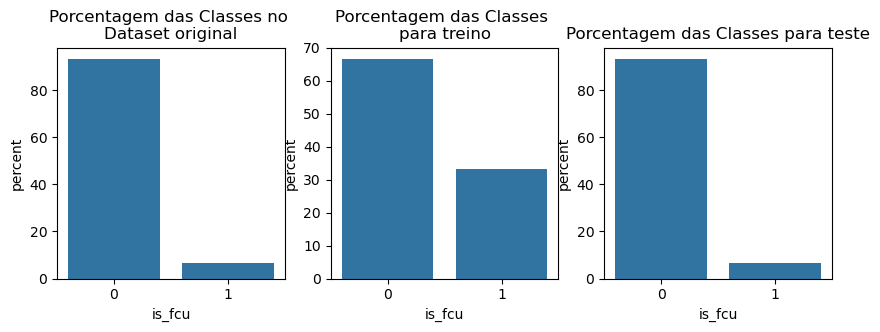

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
axes = axes.flatten()

sns.countplot(pd.DataFrame(y), x="is_fcu", stat="percent", ax=axes[0]).set(title="Porcentagem das Classes no \nDataset original")
sns.countplot(pd.DataFrame(y_train_b), x="is_fcu", stat="percent", ax=axes[1]).set(title="Porcentagem das Classes \npara treino")
sns.countplot(pd.DataFrame(y_test), x="is_fcu", stat="percent", ax=axes[2]).set(title="Porcentagem das Classes para teste")


# Modelagem

## Melhor modelo

In [15]:
models = {
    'DecisionTree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'RandomForest': RandomForestClassifier(random_state=RANDOM_STATE),
    'GradientBoosting': GradientBoostingClassifier(random_state=RANDOM_STATE),
    'AdaBoost': AdaBoostClassifier(algorithm='SAMME',random_state=RANDOM_STATE),
    'XGBoost': XGBClassifier(random_state=RANDOM_STATE),
    'KNN': KNeighborsClassifier(),
    'HistGradientBoostingClassifier': HistGradientBoostingClassifier(random_state=RANDOM_STATE),
    #'CatBoostClassifier': CatBoostClassifier(random_state=RANDOM_STATE)
}

In [16]:
results_cv = {}


for name, model in models.items():
    scores = cross_validate(
        model,
        X_train_b,
        y_train_b,
        scoring=('accuracy', 'precision', 'recall', 'roc_auc', 'f1'),
        cv=10,
        return_estimator=True,
        n_jobs=-1)
    results_cv[name] = scores

In [17]:
resultado_simplificado = { }
resultado_simplificado_dp = {}
for key, value in results_cv.items():
  resultado_simplificado[key] =  {
      'accuracy': value['test_accuracy'].mean(),
      'precision': value['test_precision'].mean(),
      'recall' : value['test_recall'].mean(),
      'roc_auc' : value['test_roc_auc'].mean(),
      'f1' : value['test_f1'].mean(),
  }

  resultado_simplificado_dp[key] =  {
      'accuracy': value['test_accuracy'].std(),
      'precision': value['test_precision'].std(),
      'recall' : value['test_recall'].std(),
      'roc_auc' : value['test_roc_auc'].std(),
      'f1' : value['test_f1'].std(),
  }

  print(f"{key} CV accuracy: {resultado_simplificado[key]['accuracy']} ± {resultado_simplificado_dp[key]['accuracy']}")
  print(f"{key} CV precision: {resultado_simplificado[key]['precision']} ± {resultado_simplificado_dp[key]['precision']}")
  print(f"{key} CV recall: {resultado_simplificado[key]['recall']} ± {resultado_simplificado_dp[key]['recall']}")
  print(f"{key} CV roc_auc: {resultado_simplificado[key]['roc_auc']} ± {resultado_simplificado_dp[key]['roc_auc']}")
  print(f"{key} CV f1: {resultado_simplificado[key]['f1']} ± {resultado_simplificado_dp[key]['f1']}")




DecisionTree CV accuracy: 0.9153584270290027 ± 0.019029626371313328
DecisionTree CV precision: 0.8619713715377859 ± 0.004719310579700138
DecisionTree CV recall: 0.8880734204611672 ± 0.06443195975272935
DecisionTree CV roc_auc: 0.9085347646585683 ± 0.030359271784555875
DecisionTree CV f1: 0.8736676471259106 ± 0.035354708859343276
RandomForest CV accuracy: 0.9457723288779839 ± 0.02157169047685177
RandomForest CV precision: 0.9093190262983588 ± 0.00801851837953228
RandomForest CV recall: 0.9300604107455019 ± 0.06984976692342196
RandomForest CV roc_auc: 0.9870938553764999 ± 0.009886482486723401
RandomForest CV f1: 0.918171161626194 ± 0.03796860955348067
GradientBoosting CV accuracy: 0.9094252597027686 ± 0.020095992148810804
GradientBoosting CV precision: 0.8622408513698826 ± 0.006758137791598315
GradientBoosting CV recall: 0.866421757381884 ± 0.06678580702714607
GradientBoosting CV roc_auc: 0.9685437281906643 ± 0.01397375607086637
GradientBoosting CV f1: 0.86305177750171 ± 0.03818799286120

In [18]:
mean_results = pd.DataFrame(resultado_simplificado)
std_results = pd.DataFrame(resultado_simplificado_dp)

In [19]:
mean_results.head()

,DecisionTree,RandomForest,GradientBoosting,AdaBoost,XGBoost,KNN,HistGradientBoostingClassifier
accuracy,0.915358,0.945772,0.909425,0.890423,0.933808,0.899981,0.923941
precision,0.861971,0.909319,0.862241,0.840989,0.893691,0.795855,0.879399
recall,0.888073,0.930060,0.866422,0.827264,0.909335,0.941529,0.894364
roc_auc,0.908535,0.987094,0.968544,0.954215,0.982116,0.958165,0.977082
f1,0.873668,0.918171,0.863052,0.832976,0.900104,0.862565,0.885502


In [20]:
from scipy.stats import ttest_rel

# Define the models to compare (DecisionTree and XGBoost)
models_to_test = ['DecisionTree', 'XGBoost', 'RandomForest']

# Create an empty list to store the test results
results_list = []

# Function to perform the paired t-test and append results to the list
def perform_t_test(reference_model, target_model, metric='test_roc_auc'):
    ref_scores = results_cv[reference_model][metric]
    target_scores = results_cv[target_model][metric]
    
    # Perform paired t-test
    t_stat, p_value = ttest_rel(ref_scores, target_scores)
    
    # Determine whether to reject the null hypothesis
    confidence_level = 0.95
    significant = 'Yes' if p_value < (1 - confidence_level) else 'No'
    
    # Append the result to the list
    results_list.append({
        'Reference Model': reference_model,
        'Compared Model': target_model,
        'Metric': metric,
        'T-statistic': t_stat,
        'P-value': p_value,
        'Significant Difference (95%)': significant
    })

# Loop through all models and compare with DecisionTree and XGBoost
for ref_model in models_to_test:
    for model_name in results_cv.keys():
        if model_name != ref_model:  # Avoid comparing the model with itself
            perform_t_test(ref_model, model_name, 'test_recall')

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results_list)

# Display the DataFrame

results_df


,Reference Model,Compared Model,Metric,T-statistic,P-value,Significant Difference (95%)
0,DecisionTree,RandomForest,test_recall,-19.172144,1.317801e-08,Yes
1,DecisionTree,GradientBoosting,test_recall,7.816350,2.663461e-05,Yes
2,DecisionTree,AdaBoost,test_recall,19.617512,1.076461e-08,Yes
3,DecisionTree,XGBoost,test_recall,-7.420793,4.014066e-05,Yes
4,DecisionTree,KNN,test_recall,-2.475235,3.526605e-02,Yes
5,DecisionTree,HistGradientBoostingClassifier,test_recall,-2.989958,1.520196e-02,Yes
6,XGBoost,DecisionTree,test_recall,7.420793,4.014066e-05,Yes
7,XGBoost,RandomForest,test_recall,-11.815774,8.783583e-07,Yes
8,XGBoost,GradientBoosting,test_recall,21.495938,4.801608e-09,Yes
9,XGBoost,AdaBoost,test_recall,21.713337,4.392702e-09,Yes


# Melhor Modelo

In [21]:
def model_eval(model,X_train,y_train,X_test,y_test,classes=None,
                           normalize='true',cmap='Blues',label=''):

    """Example function with PEP 484 type annotations.

        Args:
            model: The Model Classifier.
            X_train: X_train being used to fit model (could be scaled or not).
            y_train: y_train being used to fit model and to get train accuracy.
            X_test: X_test to get test predictions.
            y_test: y_test used to get test accuracy

        Returns:
            Model Accuracy. Confusion Matrix, ROC Curve, and best params for GridSearch

    """
    
    
    #FITTING MODEL WITH TRAIN DATA
    #model.fit(X_train,y_train)   
      
    #GETTING TRAIN PREDICTIONS
    y_hat_train = model.predict(X_train)
    
    #GETING TEST PREDICTIONS
    y_hat_test = model.predict(X_test)
    
    dashes = '---'*20
    
    if isinstance(model,GridSearchCV):
        grid_header = "GRID SEARCH FOUND THE FOLLOWING OPTIMAL PARAMETERS: "
        print(dashes,grid_header,dashes,sep='\n')
        best_parameters = model.best_params_
        for param_name in sorted(best_parameters.keys()):
            print("%s: %r" % (param_name, best_parameters[param_name]))
    
    #GETTING ACCURACY SCORE FOR TRAIN AND TEST
    
    if len(label)>0:
        accuracy_header = f'{label} ACCURACY'
    else:
        accuracy_header = 'MODEL ACCURACY'
    print(dashes,accuracy_header,dashes,sep='\n')
    training_accuracy = accuracy_score(y_train, y_hat_train)
    testing_accuracy = accuracy_score(y_test, y_hat_test)
    
    print(f'TESTING ACCURACY: {round(testing_accuracy*100,2)}%')
    
     
    if len(label)>0:
        accuracy_header = f'{label} RECALL'
    else:
        accuracy_header = 'MODEL RECALL'

    print(dashes,accuracy_header,dashes,sep='\n')
    training_recall = recall_score(y_train, y_hat_train)
    testing_recall = recall_score(y_test, y_hat_test)
    
    print(f'TESTING RECALL: {round(testing_recall*100,2)}%')

    #CLASSIFICATION REPORT AND SCORES
    test_header = "CLASSIFICATION REPORT"
    
    #ADDING LABEL IF GIVEN
    if len(label)>0:
        test_header += f" USING {label}"
    
    # PRINT CLASSIFICATION REPORT
    
    print(dashes,test_header,dashes,sep='\n')

    print(classification_report(y_test,y_hat_test,
                                    target_names=classes))

    print(dashes+"\n\n")
    
    

    # MAKE FIGURE
    fig, axes = plt.subplots(figsize=(10,4),ncols=2)
    
    # PLOTTING CONFUSION MATRIX 

    
    #cm = confusion_matrix(, labels=model.classes_)
    ConfusionMatrixDisplay.from_predictions(y_test, y_hat_test, labels=model.classes_, ax=axes[0], cmap=cmap)
    axes[0].set(title='Confusion Matrix')

    
    
    plt.show()


### Random Forest

In [22]:
param_grid_random_forest = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes': [10, 50],
    'class_weight': [None, 'balanced']
}

param_grid_random_forest = {
    'class_weight': ['balanced'],
    'max_depth': [20],
    'min_samples_split': [20],


}

In [23]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)


grid_search_RandomForest = GridSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE),
    param_grid_random_forest,
    cv=skf,
    scoring='recall',
    n_jobs=-1,
    verbose=3 
)
grid_search_RandomForest.fit(X_train_b, y_train_b)

print("Melhores parametros Para  RandomForestClassifier:", grid_search_RandomForest.best_params_)
print("Melhor CV recall para RandomForestClassifier:", grid_search_RandomForest.best_score_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END class_weight=balanced, max_depth=20, min_samples_split=20;, score=0.935 total time=  13.1s
[CV 2/10] END class_weight=balanced, max_depth=20, min_samples_split=20;, score=0.936 total time=  13.2s
[CV 4/10] END class_weight=balanced, max_depth=20, min_samples_split=20;, score=0.943 total time=  13.2s
[CV 5/10] END class_weight=balanced, max_depth=20, min_samples_split=20;, score=0.931 total time=  13.2s
[CV 7/10] END class_weight=balanced, max_depth=20, min_samples_split=20;, score=0.941 total time=  13.3s
[CV 6/10] END class_weight=balanced, max_depth=20, min_samples_split=20;, score=0.945 total time=  13.3s
[CV 8/10] END class_weight=balanced, max_depth=20, min_samples_split=20;, score=0.943 total time=  13.2s
[CV 10/10] END class_weight=balanced, max_depth=20, min_samples_split=20;, score=0.945 total time=  13.2s
[CV 3/10] END class_weight=balanced, max_depth=20, min_samples_split=20;, score=0.948 total time= 

In [24]:
y_hat_train = grid_search_RandomForest.predict(X_train_b)
training_recall = recall_score(y_train_b, y_hat_train)
print(f'TESTING RECALL: {training_recall}%')


TESTING RECALL: 0.9743489710328684%


------------------------------------------------------------
GRID SEARCH FOUND THE FOLLOWING OPTIMAL PARAMETERS: 
------------------------------------------------------------
class_weight: 'balanced'
max_depth: 20
min_samples_split: 20
------------------------------------------------------------
RandomForest ACCURACY
------------------------------------------------------------
TESTING ACCURACY: 91.63%
------------------------------------------------------------
RandomForest RECALL
------------------------------------------------------------
TESTING RECALL: 73.75%
------------------------------------------------------------
CLASSIFICATION REPORT USING RandomForest
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.93      0.95     10232
           1       0.43      0.74      0.54       739

    accuracy                           0.92     10971
   macro avg       0.70      0.83      0.75     1

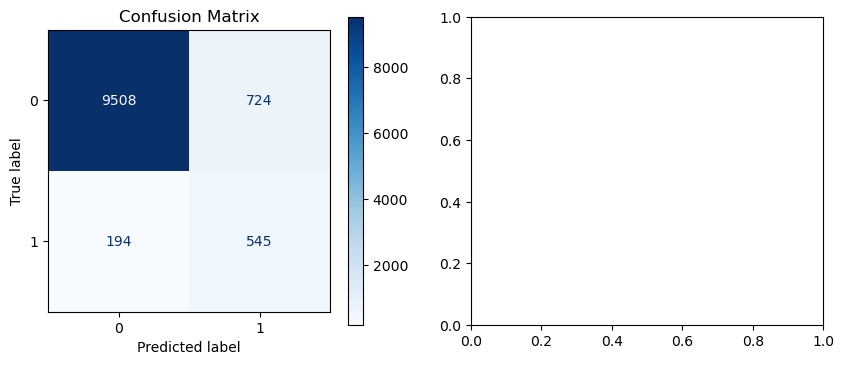

In [25]:
model_eval(grid_search_RandomForest,X_train_b, y_train_b, X_test_standScaler, y_test,label='RandomForest')

In [26]:
X_train_b

,Households connected to water supply network (%),Households connected to sewerage system (%),Households solid waste collection (%),Number of private residences,Number of buildings areas,Average building area,Average slope,railway_intersection,highway_intersection,power_intersection,aeroway_intersection,natural_intersection,waterway_intersection
0,1.000000,1.000000,1.000000,14.000000,28.000000,136.261782,17.682005,0,1,0,0,0,1
1,1.000000,1.000000,1.000000,135.000000,92.000000,89.270754,0.000000,0,0,0,0,0,0
2,1.000000,0.927928,1.000000,114.000000,90.000000,62.985117,28.600999,0,0,0,0,0,0
3,1.000000,1.000000,1.000000,55.000000,98.000000,85.341659,12.675324,0,0,0,0,0,0
4,0.944444,1.000000,1.000000,28.000000,50.000000,88.593745,3.531220,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61513,0.954636,0.886922,0.739248,154.155080,116.588236,72.753952,26.415003,0,0,0,0,0,0
61514,0.991484,0.857143,0.995742,40.956825,120.374095,64.019509,3.604695,0,0,0,0,0,0
61515,1.000000,0.996248,0.998536,213.529645,120.776284,79.837146,2.887077,0,0,0,0,0,0
61516,0.984063,0.933132,1.000000,145.515510,144.515510,64.010759,0.000000,0,0,0,0,0,0


#### Model Results

In [27]:
#standScalerAll = StandardScaler()
#x_all = apply_standard_scaler(standScalerAll, X, variables)

x_all = X

In [28]:
y_all_hat = grid_search_RandomForest.predict_proba(x_all)
y_all_hat_val = grid_search_RandomForest.predict(x_all)


In [29]:
sao_remo_poli = dados[dados['id_hex'] == '8aa81005aadffff'].index[0]
oscar_freire = dados[dados['id_hex'] == '8aa8100ea147fff'].index[0]

buracana = dados[dados['id_hex'] == '8aa81005aa8ffff'].index[0]

test = dados[dados['id_hex'] == '8aa8103b4a37fff'].index[0]

In [30]:
y_all_hat[buracana]

array([0.01135427, 0.98864573])

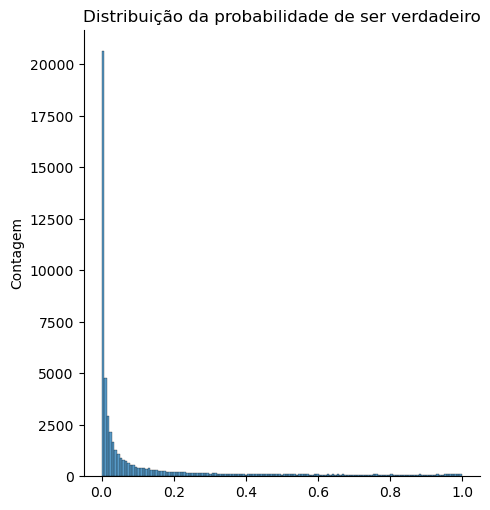

In [31]:
sns.displot(y_all_hat[:, 1]). set(title='Distribuição da probabilidade de ser verdadeiro', ylabel='Contagem')


In [32]:
all_recall = recall_score(y, y_all_hat_val)
    
print(f'All RECALL: {round(all_recall*100,2)}%')

All RECALL: 85.63%


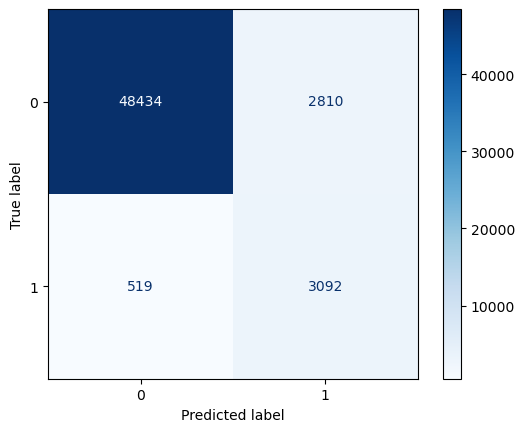

In [33]:

# PLOTTING CONFUSION MATRIX 
   
ConfusionMatrixDisplay.from_predictions(y, y_all_hat_val, labels=grid_search_RandomForest.classes_, cmap='Blues')

# Shape Random Forest

In [34]:
explainer = shap.TreeExplainer(grid_search_RandomForest.best_estimator_, X_train_b)
shap.plots.initjs()

In [35]:
explainer.expected_value

array([0.60435726, 0.39564274])

In [36]:
shap_values = explainer(x_all, check_additivity=False)

100%|===================| 109697/109710 [63:03<00:00]        

In [37]:
shap_values.shape

(54855, 13, 2)

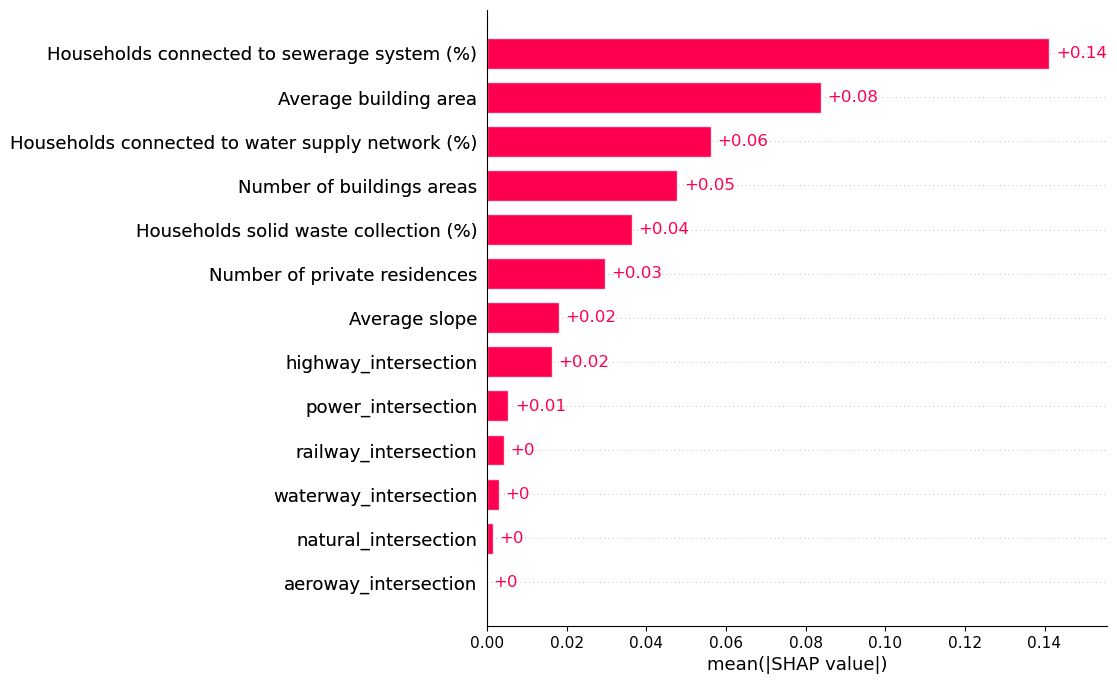

In [38]:
shap.plots.bar(shap_values[:, :, 1], max_display=16)

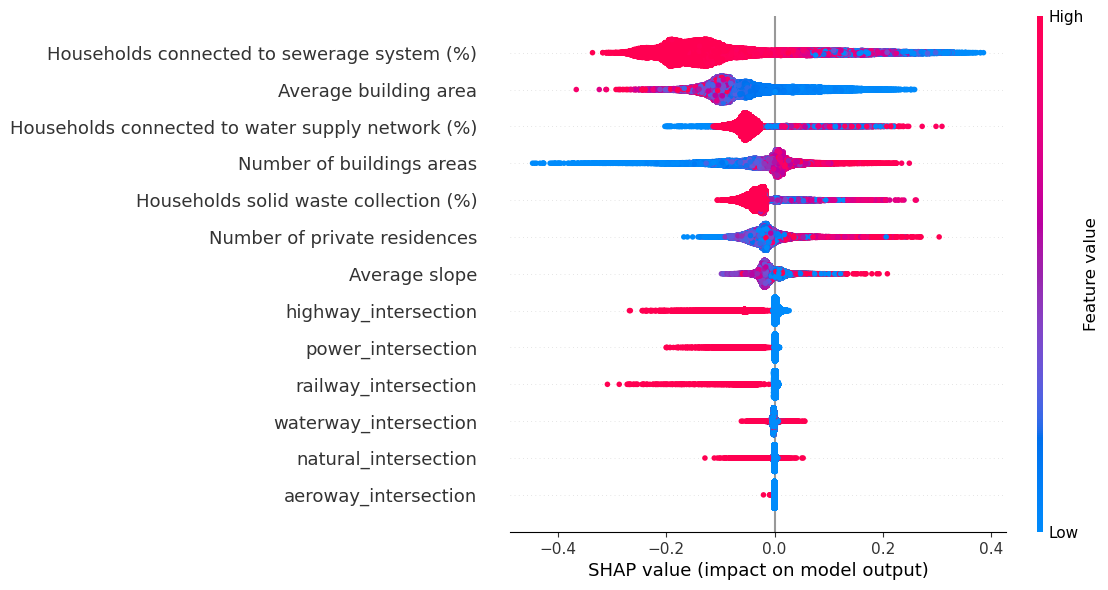

In [39]:
shap.plots.beeswarm(shap_values[:, :, 1], max_display=16)


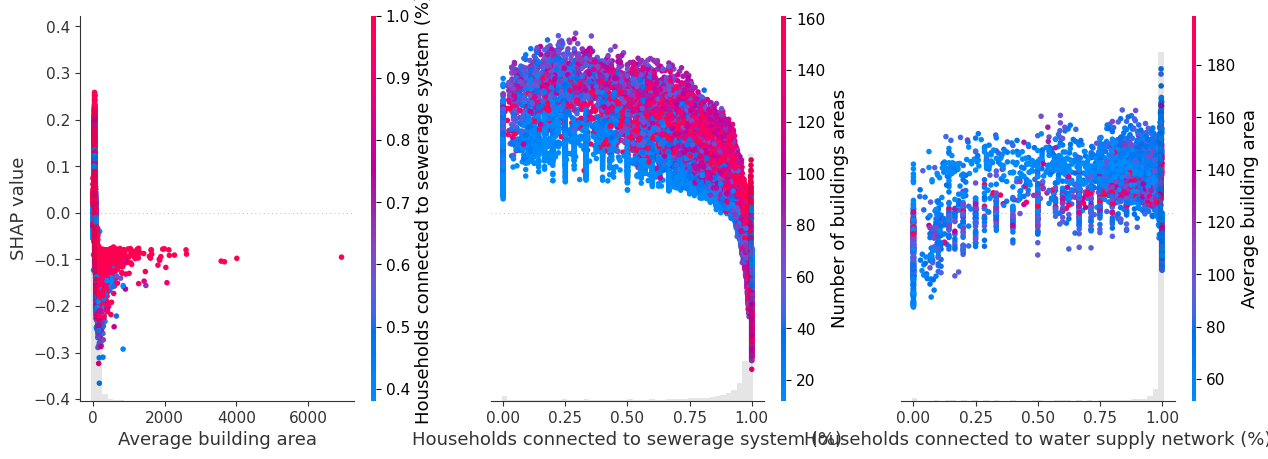

In [41]:

shap.plots.scatter(shap_values[:, ['Average building area', 'Households connected to sewerage system (%)', 'Households connected to water supply network (%)'], 1], color=shap_values[:, :, 1])


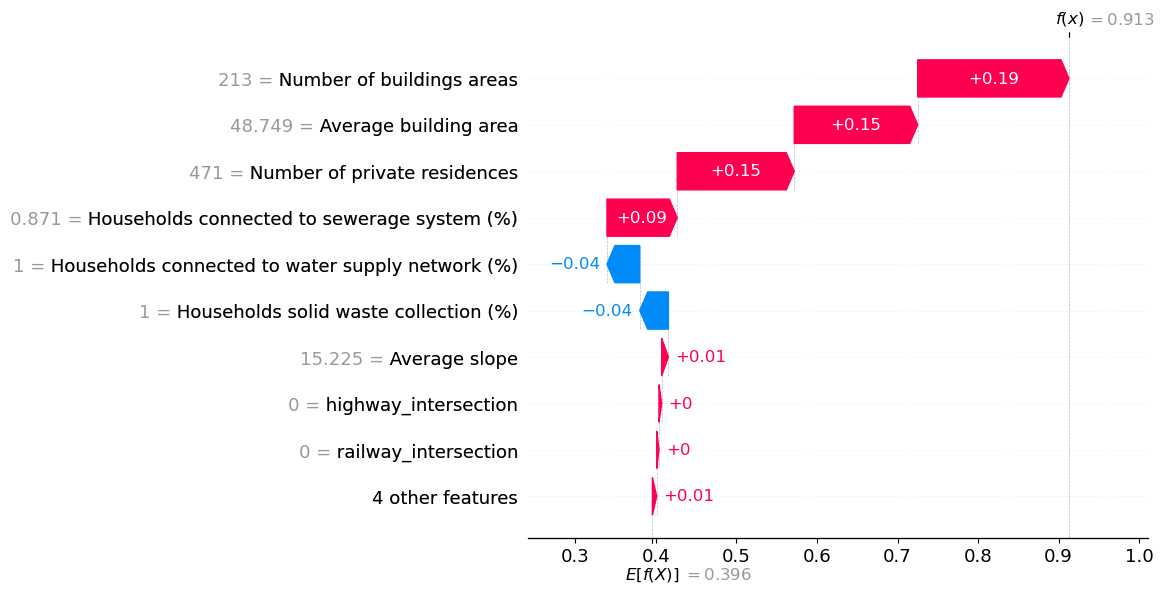

In [42]:
# São Remo poligono 
shap.plots.waterfall(shap_values[sao_remo_poli, :, 1])

In [43]:
shap.force_plot(explainer.expected_value[1], shap_values[sao_remo_poli, :, 1].values, feature_names=(x_all.columns))

In [44]:
condition_outlier = y_all_hat_val == 1
qnt_pred_as_true = condition_outlier.sum()

true_pred =  sum(y[y_all_hat_val == 1])

print(qnt_pred_as_true, true_pred)

5902 3092


In [45]:
falso_positivo_condition = ((y_all_hat_val == 1) & (y == 0))
falso_negativo_condition = (y_all_hat_val  == 0) & (y == 1)
true_condition = (y_all_hat_val == 1) & (y == 1)
false_condition = (y_all_hat_val == 0) & (y == 0)


### Analise dos erros tipo i e ii


In [46]:
# Analise falso positivo
T = x_all[falso_positivo_condition]
sh_fp = explainer(T)


100%|===================| 5619/5620 [04:36<00:00]        

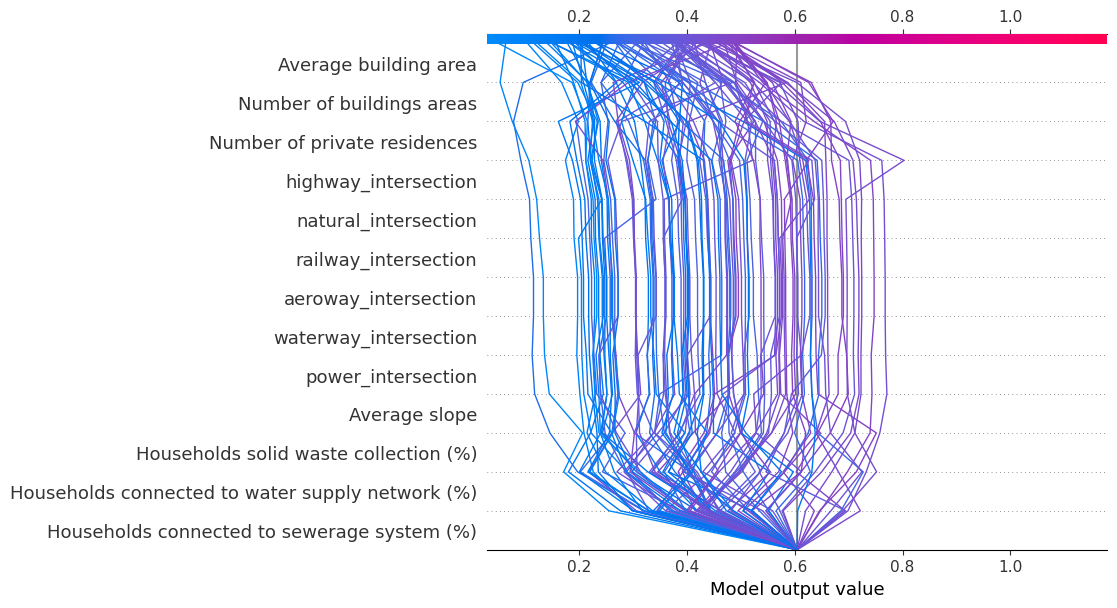

In [47]:
with warnings.catch_warnings():
    r = shap.decision_plot(explainer.expected_value[0], sh_fp[:100, :, 0].values, T[:100], feature_order="hclust", return_objects=True, ignore_warnings=True)

In [48]:
# Analise falso negativo
T = x_all[falso_negativo_condition]
sh_fn = explainer(T)


 99%|===================| 1026/1038 [00:41<00:00]        

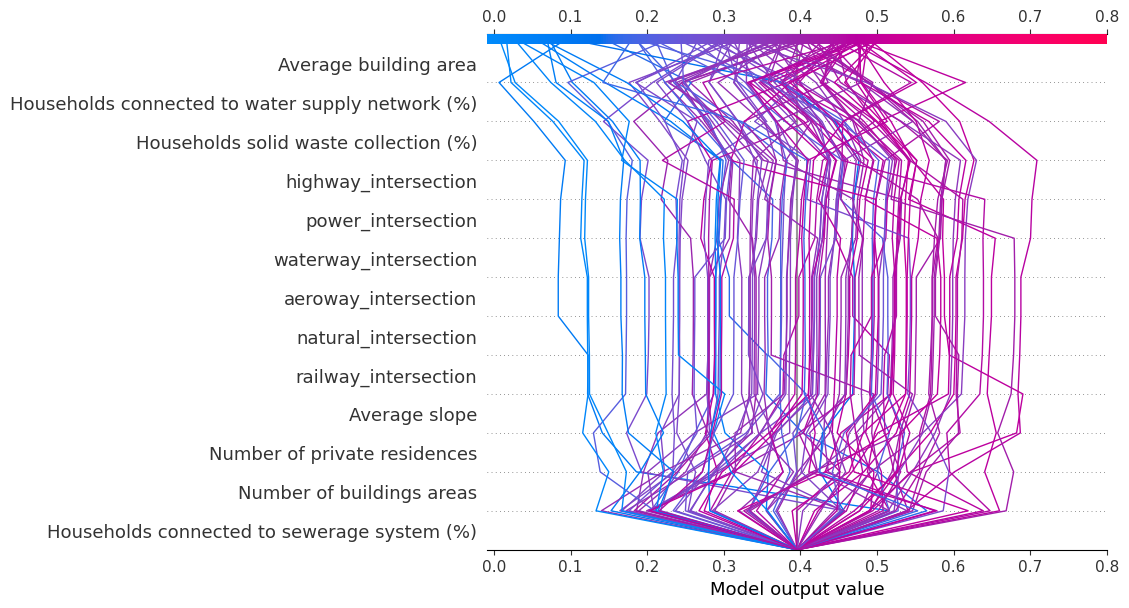

In [49]:
r = shap.decision_plot(explainer.expected_value[1], sh_fn[:100, :, 1].values, T, feature_order="hclust", return_objects=True)

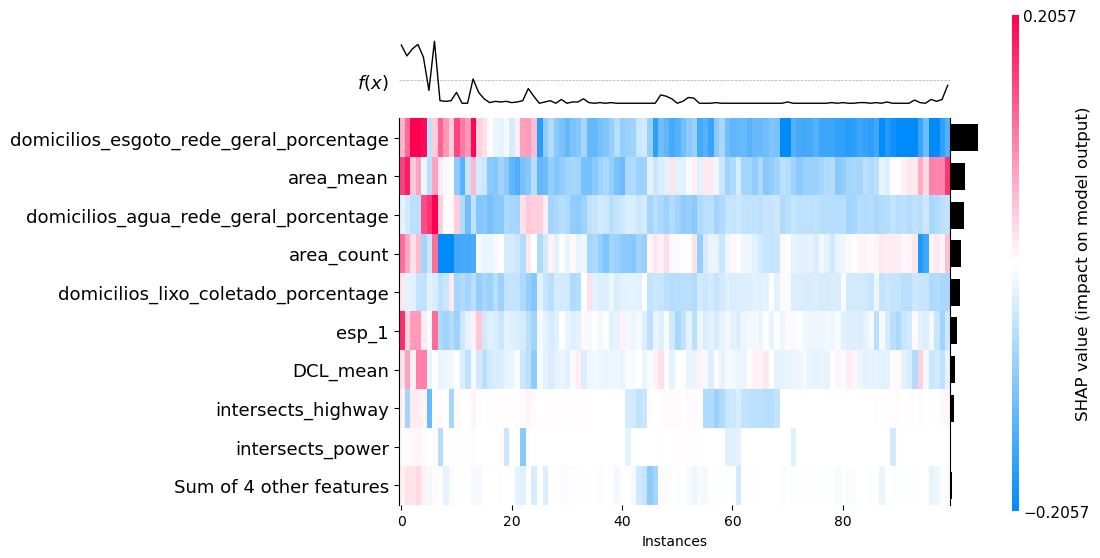

<Axes: xlabel='Instances'>

In [155]:
shap.plots.heatmap(shap_values[:100, : , 1])

In [50]:
import pickle

# Assuming `shap_values` is the result from `explainer(x_all)`
with open("data/model/shap_values_model_all.pkl", "wb") as file:
    pickle.dump(shap_values, file)

In [167]:
with open("data/model/shap_values_model1.pkl", "rb") as file:
    shap_values_test = pickle.load(file)

## Saving probability and classification

In [51]:
dados['is_fav_prob_model1'] = y_all_hat[:, 1]

dados.loc[falso_positivo_condition, 'model1_result'] = 'FP'
dados.loc[falso_negativo_condition, 'model1_result'] = 'FN'
dados.loc[true_condition, 'model1_result'] = 'P'
dados.loc[false_condition, 'model1_result'] = 'N'


In [52]:
dados.to_file("data/generated/WGS84_hex_sp_model_all.gpkg", driver="GPKG")